In [ ]:
# setting up environment
!pip install contractions
!pip install pyLDAvis==2.1.2
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U

In [ ]:
# imports statements, make sure utils.py is in the right directory
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import seaborn as sns

from collections import Counter
from utils import clean_data, preprocessing

import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Load amazon review data - Electronics
df = pd.read_csv('../content/amazon_reviews_us_Electronics_v1_00.tsv', sep='\t', header=None, on_bad_lines='skip')

df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0            1               2           3               4   \
0  marketplace  customer_id       review_id  product_id  product_parent   
1           US     41409413  R2MTG1GCZLR2DK  B00428R89M       112201306   
2           US     49668221  R2HBOEM8LE9928  B000068O48       734576678   
3           US     12338275  R1P4RW1R9FDPEE  B000GGKOG8       614448099   
4           US     38487968  R1EBPM82ENI67M  B000NU4OTA        72265257   

                                                  5                 6   \
0                                      product_title  product_category   
1  yoomall 5M Antenna WIFI RP-SMA Female to Male ...       Electronics   
2         Hosa GPM-103 3.5mm TRS to 1/4" TRS Adaptor       Electronics   
3        Channel Master Titan 2 Antenna Preamplifier       Electronics   
4  LIMTECH Wall charger + USB Hotsync & Charging ...       Electronics   

            7              8            9     10                 11  \
0  star_rating  helpful_votes  total_votes  vine  verified_purchase   
1            5              0            0     N                  Y   
2            5              0            0     N                  Y   
3            5              1            1     N                  Y   
4            1              0            0     N                  Y   

                         12                        13           14  
0           review_headline               review_body  review_date  
1                Five Stars             As described.   2015-08-31  
2  It works as advertising.  It works as advertising.   2015-08-31  
3                Five Stars               Works pissa   2015-08-31  
4                  One Star      Did not work at all.   2015-08-31

<Axes: ylabel='Density'>

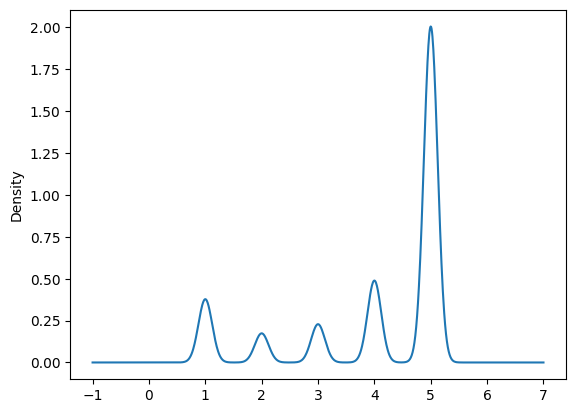

In [ ]:
# getting the column names
df.columns = list(df.iloc[0])

df['star_rating'] = pd.to_numeric(df['star_rating'], errors='coerce')

# plot distribution of values in points column
df['star_rating'].plot(kind='kde')

<Axes: ylabel='Frequency'>

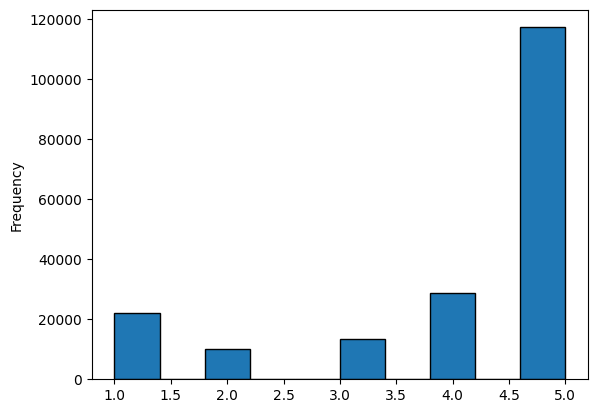

In [ ]:
# histogram
df['star_rating'].plot(kind='hist', edgecolor='black')

In [ ]:
# getting first 50,000 rows (for computational reasons)
df = df.iloc[1:50000]

df.head()

marketplace customer_id       review_id  product_id product_parent  \
1          US    41409413  R2MTG1GCZLR2DK  B00428R89M      112201306   
2          US    49668221  R2HBOEM8LE9928  B000068O48      734576678   
3          US    12338275  R1P4RW1R9FDPEE  B000GGKOG8      614448099   
4          US    38487968  R1EBPM82ENI67M  B000NU4OTA       72265257   
5          US    23732619  R372S58V6D11AT  B00JOQIO6S      308169188   

                                       product_title product_category  \
1  yoomall 5M Antenna WIFI RP-SMA Female to Male ...      Electronics   
2         Hosa GPM-103 3.5mm TRS to 1/4" TRS Adaptor      Electronics   
3        Channel Master Titan 2 Antenna Preamplifier      Electronics   
4  LIMTECH Wall charger + USB Hotsync & Charging ...      Electronics   
5     Skullcandy Air Raid Portable Bluetooth Speaker      Electronics   

   star_rating helpful_votes total_votes vine verified_purchase  \
1          5.0             0           0    N                 Y   
2          5.0             0           0    N                 Y   
3          5.0             1           1    N                 Y   
4          1.0             0           0    N                 Y   
5          5.0             1           1    N                 Y   

                 review_headline  \
1                     Five Stars   
2       It works as advertising.   
3                     Five Stars   
4                       One Star   
5  Overall pleased with the item   

                                         review_body review_date  
1                                      As described.  2015-08-31  
2                           It works as advertising.  2015-08-31  
3                                        Works pissa  2015-08-31  
4                               Did not work at all.  2015-08-31  
5  Works well. Bass is somewhat lacking but is pr...  2015-08-31

<Axes: xlabel='star_rating', ylabel='count'>

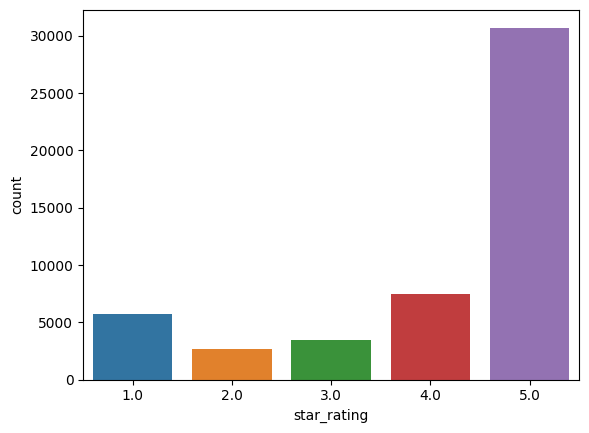

In [ ]:
# distribution of ratings in the original data
sns.countplot(x = 'star_rating', data=df)

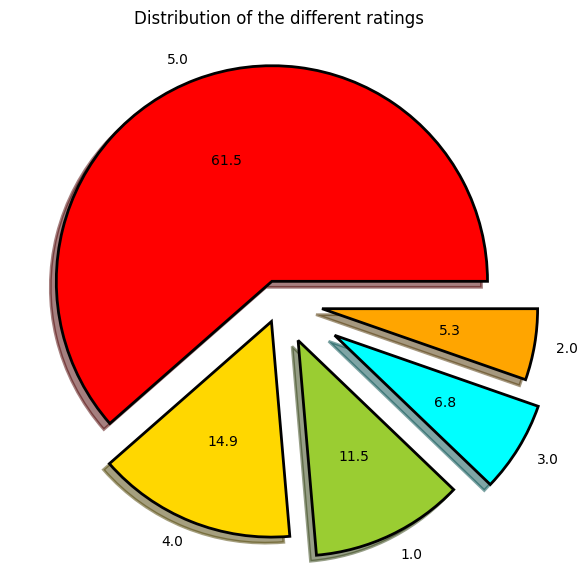

In [ ]:
# pie chart
fig = plt.figure(figsize=(7,7))
colors = ("red","gold","yellowgreen","cyan","orange")

wp = {'linewidth':2, 'edgecolor':'black'}
tags = df['star_rating'].value_counts()

explode = (0.1,0.1,0.2,0.3,0.2)
tags.plot(kind='pie', autopct='%1.1f',colors=colors, shadow=True,
          startangle=0, wedgeprops=wp, explode=explode, label='')

plt.title('Distribution of the different ratings')
plt.show()

In [ ]:
# list of columns in the data we don't need
cols = ["marketplace", "customer_id", "review_id", "product_id", "product_parent",
        "product_category", "vine"]

# drop those columnss
data_df = df.drop(columns=cols)

data_df.head()

product_title  star_rating  \
1  yoomall 5M Antenna WIFI RP-SMA Female to Male ...          5.0   
2         Hosa GPM-103 3.5mm TRS to 1/4" TRS Adaptor          5.0   
3        Channel Master Titan 2 Antenna Preamplifier          5.0   
4  LIMTECH Wall charger + USB Hotsync & Charging ...          1.0   
5     Skullcandy Air Raid Portable Bluetooth Speaker          5.0   

  helpful_votes total_votes verified_purchase                review_headline  \
1             0           0                 Y                     Five Stars   
2             0           0                 Y       It works as advertising.   
3             1           1                 Y                     Five Stars   
4             0           0                 Y                       One Star   
5             1           1                 Y  Overall pleased with the item   

                                         review_body review_date  
1                                      As described.  2015-08-31  
2                           It works as advertising.  2015-08-31  
3                                        Works pissa  2015-08-31  
4                               Did not work at all.  2015-08-31  
5  Works well. Bass is somewhat lacking but is pr...  2015-08-31

In [ ]:
# remove non-verified user reviews
# this reduces the probability of bot reviews
# though it does eliminate some reviews which weren't/haven't been verified yet
i = df[(df.verified_purchase == 'N')].index

data_df = data_df.drop(i)

data_df.head()

product_title  star_rating  \
1  yoomall 5M Antenna WIFI RP-SMA Female to Male ...          5.0   
2         Hosa GPM-103 3.5mm TRS to 1/4" TRS Adaptor          5.0   
3        Channel Master Titan 2 Antenna Preamplifier          5.0   
4  LIMTECH Wall charger + USB Hotsync & Charging ...          1.0   
5     Skullcandy Air Raid Portable Bluetooth Speaker          5.0   

  helpful_votes total_votes verified_purchase                review_headline  \
1             0           0                 Y                     Five Stars   
2             0           0                 Y       It works as advertising.   
3             1           1                 Y                     Five Stars   
4             0           0                 Y                       One Star   
5             1           1                 Y  Overall pleased with the item   

                                         review_body review_date  
1                                      As described.  2015-08-31  
2                           It works as advertising.  2015-08-31  
3                                        Works pissa  2015-08-31  
4                               Did not work at all.  2015-08-31  
5  Works well. Bass is somewhat lacking but is pr...  2015-08-31

In [ ]:
# clean data - preprocessing
data_df.product_title = data_df.product_title.apply(clean_data)

data_df.head()

product_title  star_rating  \
1  yoomall antenna wifi rpsma female male extensi...          5.0   
2                               hosa trs trs adaptor          5.0   
3          channel master titan antenna preamplifier          5.0   
4  limtech wall charger usb hotsync charging dock...          1.0   
5     skullcandy air raid portable bluetooth speaker          5.0   

  helpful_votes total_votes verified_purchase                review_headline  \
1             0           0                 Y                     Five Stars   
2             0           0                 Y       It works as advertising.   
3             1           1                 Y                     Five Stars   
4             0           0                 Y                       One Star   
5             1           1                 Y  Overall pleased with the item   

                                         review_body review_date  
1                                      As described.  2015-08-31  
2                           It works as advertising.  2015-08-31  
3                                        Works pissa  2015-08-31  
4                               Did not work at all.  2015-08-31  
5  Works well. Bass is somewhat lacking but is pr...  2015-08-31

In [ ]:
data_df = data_df[data_df.review_body.apply(type) == str]

# Filter rows with reviews of length 512 or less
data_df = data_df[data_df['review_body'].str.len() <= 512]

In [ ]:
# more pre-processing and getting all 5 star reviews
data_df['star_rating'] = pd.to_numeric(data_df['star_rating'], errors='coerce')

pos_reviews = data_df[data_df["star_rating"] == 5]

pos_reviews.head()

product_title  star_rating  \
1  yoomall antenna wifi rpsma female male extensi...          5.0   
2                               hosa trs trs adaptor          5.0   
3          channel master titan antenna preamplifier          5.0   
5     skullcandy air raid portable bluetooth speaker          5.0   
6  pioneer andrew jones designed bookshelf loudsp...          5.0   

  helpful_votes total_votes verified_purchase                review_headline  \
1             0           0                 Y                     Five Stars   
2             0           0                 Y       It works as advertising.   
3             1           1                 Y                     Five Stars   
5             1           1                 Y  Overall pleased with the item   
6             1           1                 Y                     Five Stars   

                                         review_body review_date  
1                                      As described.  2015-08-31  
2                           It works as advertising.  2015-08-31  
3                                        Works pissa  2015-08-31  
5  Works well. Bass is somewhat lacking but is pr...  2015-08-31  
6  The quality on these speakers is insanely good...  2015-08-31

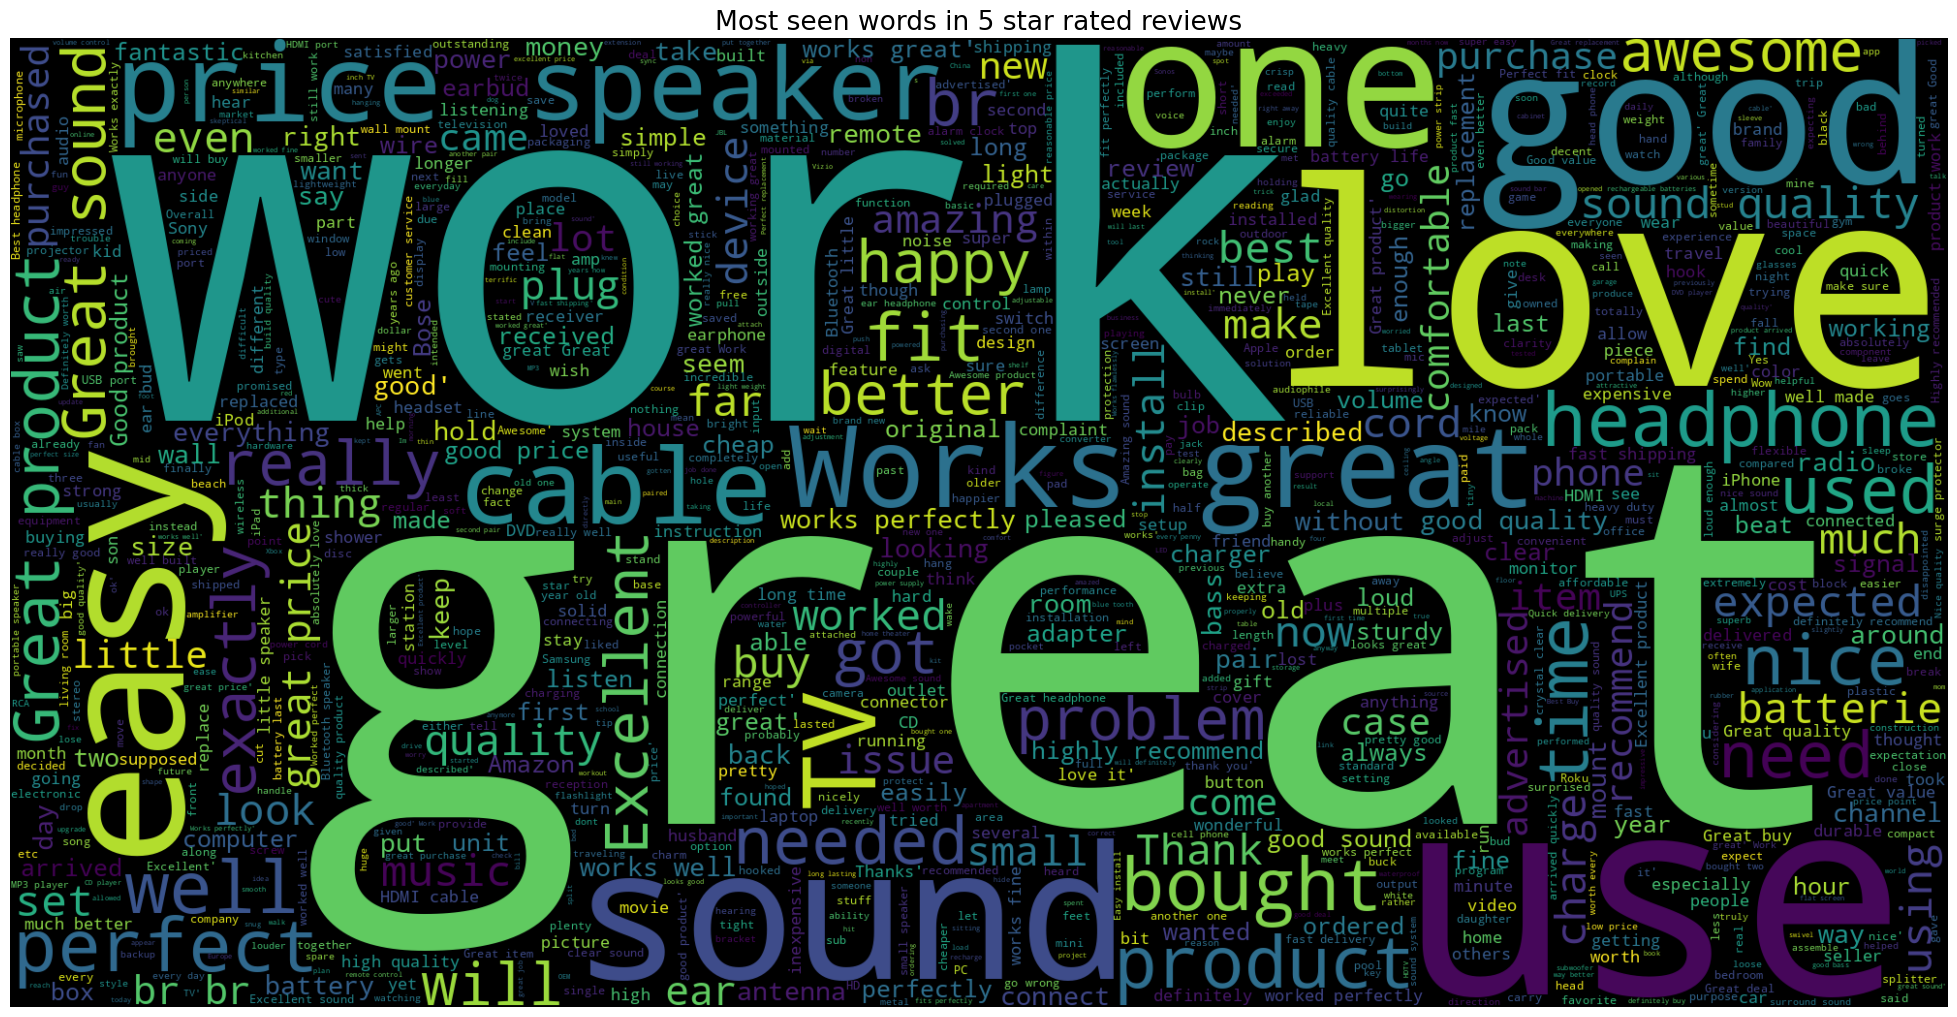

In [ ]:
# plot wordcloud
from wordcloud import WordCloud

text = []

for word in pos_reviews.review_body:
    text.append(word)

text = str(text[:])

plt.figure(figsize=(25,20), facecolor='None')

wordcloud = WordCloud(max_words=1000, width=2000, height=1000).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most seen words in 5 star rated reviews', fontsize=19)
plt.show()

In [ ]:
# get all 1 star reviews
neg_reviews = data_df[data_df.star_rating==1]

neg_reviews.head()

product_title  star_rating  \
4   limtech wall charger usb hotsync charging dock...          1.0   
13                      coby gb video player fm radio          1.0   
39  crosley cruiser deluxe portable turntable blue...          1.0   
43  tripp lite hdmi extender equalizer active repe...          1.0   
61  ggmartinsen gb mini usb port slim small multil...          1.0   

   helpful_votes total_votes verified_purchase     review_headline  \
4              0           0                 Y            One Star   
13             0           0                 Y            One Star   
39             1           1                 Y    Not happy at all   
43             0           0                 Y            One Star   
61             0           0                 Y  Does not play .wma   

                                          review_body review_date  
4                                Did not work at all.  2015-08-31  
13  Breaks very easily, and takes a while to load ...  2015-08-31  
39  We bought this for my daughter for her birthda...  2015-08-31  
43                           Did not help my problem.  2015-08-31  
61  Junk - will play MP3, but not WMA, even though...  2015-08-31

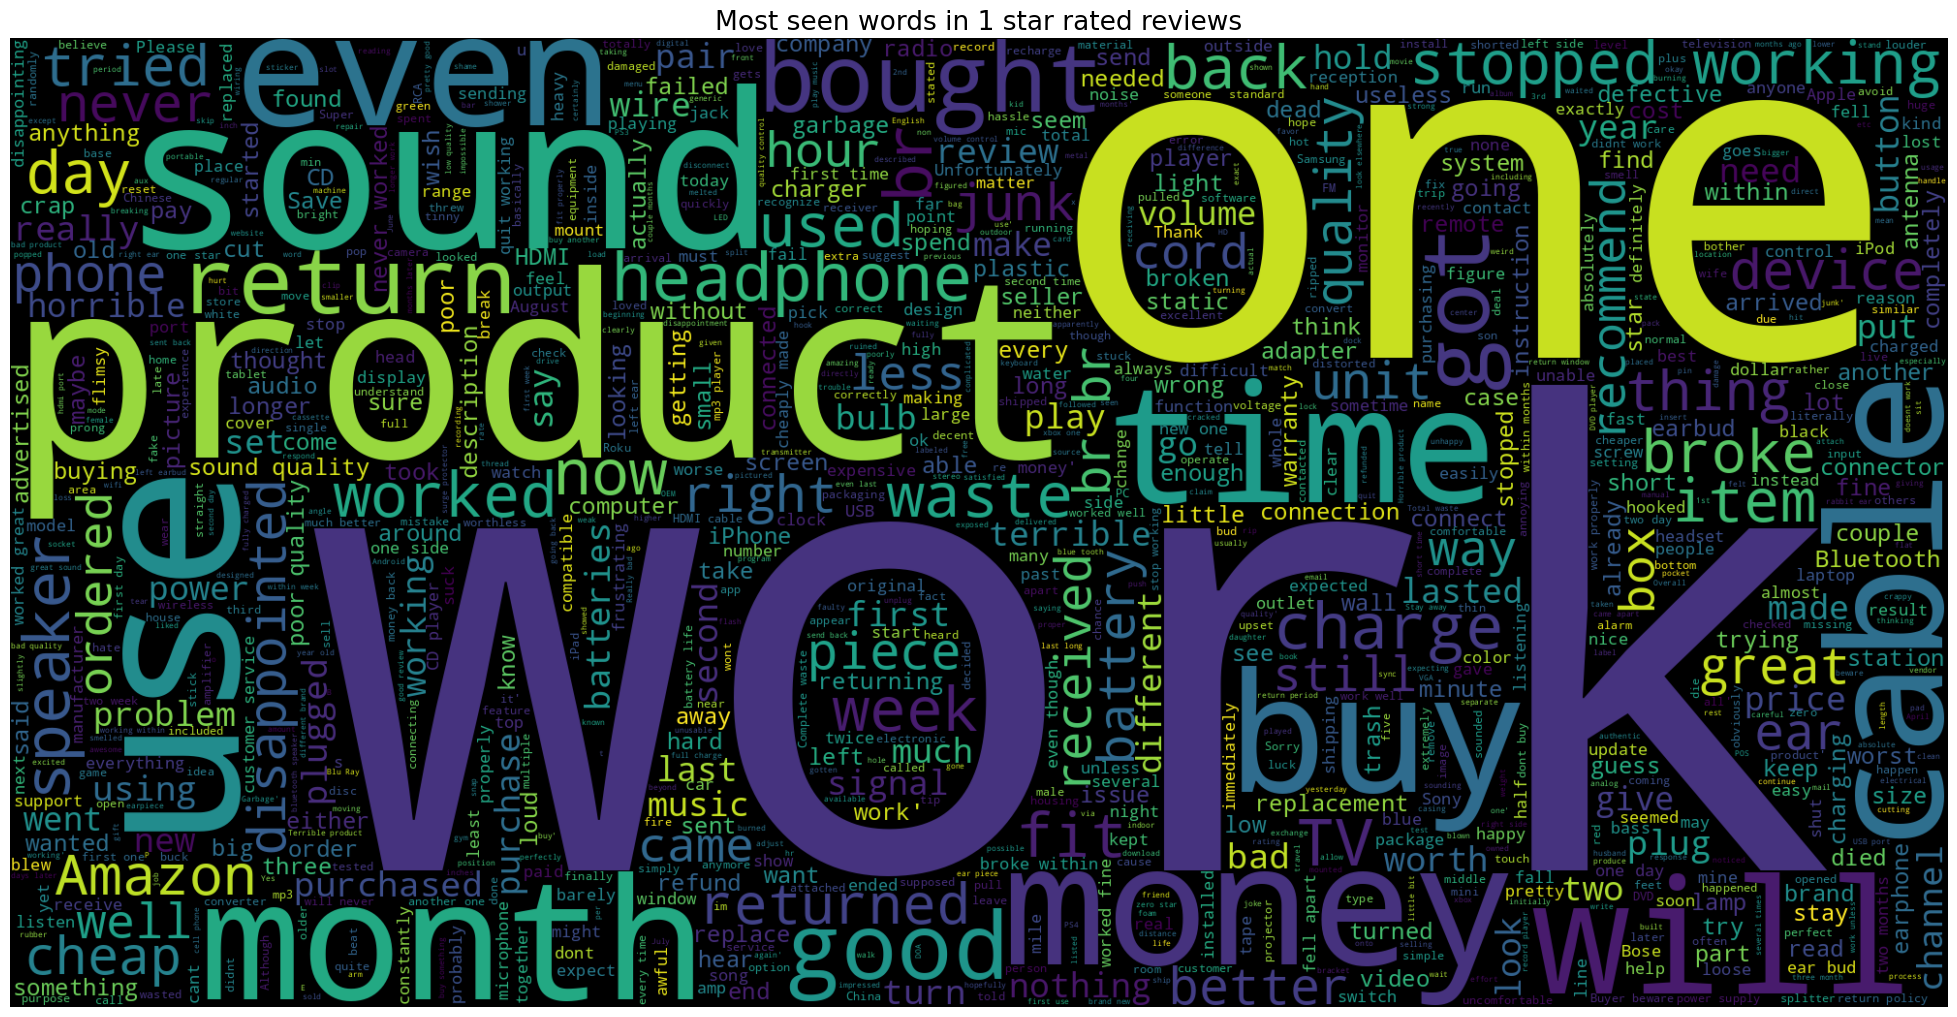

In [ ]:
# plot wordcloud
text = []

for word in neg_reviews.review_body:
    text.append(word)

text = str(text[:])

plt.figure(figsize=(25,20), facecolor='None')

wordcloud = WordCloud(max_words=1000, width=2000, height=1000).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most seen words in 1 star rated reviews', fontsize=19)
plt.show()

In [ ]:
# Topic Modeling for all 5 star reviews
from sklearn.decomposition import LatentDirichletAllocation

# Create a list of words from the reviews
reviews = pos_reviews['review_body'].tolist()
words = []
for review in reviews:
    words += review.split()

# Create a dictionary of words and their frequencies
word_counts = Counter(words)

# Create a vocabulary of the most frequent words
vocabulary = [word for word, count in word_counts.most_common(5000)]

# Create a document-term matrix
document_term_matrix = np.zeros((len(data_df), len(vocabulary)))
for i, review in enumerate(reviews):
    for word in review.split():
        if word in vocabulary:
            document_term_matrix[i, vocabulary.index(word)] += 1

# Create a Latent Dirichlet Allocation model
lda = LatentDirichletAllocation(n_components=10)

# Fit the model to the document-term matrix
lda.fit(document_term_matrix)

# Get the topics from the model
topics = lda.components_

# Print the top words in each topic
for topic in topics:
    top_words = np.argsort(topic)[-10:]
    print([vocabulary[i] for i in top_words])

['with', 'on', 'for', 'a', 'of', 'my', 'to', 'in', 'and', 'the']
['in', 'work', 'install', 'great.', 'Easy', 'great!', 'and', 'easy', 'Works', 'to']
['needed', 'exactly', 'my', 'Perfect', 'very', 'and', 'was', 'I', 'good', 'what']
['my', 'to', 'for', 'as', 'so', 'this', 'a', 'and', 'it', 'I']
['them', 'of', 'for', 'they', 'a', 'are', 'these', 'and', 'I', 'the']
['this', 'The', 'to', 'it', 'sound', 'the', 'a', 'for', 'and', 'is']
['with', 'this', 'is', 'my', 'it', 'and', 'a', 'I', 'to', 'the']
['sound.', 'happy', 'sound', 'great', 'Great', 'Excellent', 'very', 'with', 'and', 'Very']
['Good', 'with', 'price.', 'quality', 'my', 'Great', 'Works', 'great', 'the', 'for']
['fast', 'product.', 'price', 'Good', 'and', 'great', 'product', 'works', 'as', 'Great']


In [ ]:
# Create a list of words from the reviews
reviews = neg_reviews['review_body'].tolist()
words = []
for review in reviews:
    words += review.split()

# Create a dictionary of words and their frequencies
word_counts = Counter(words)

# Create a vocabulary of the most frequent words
vocabulary = [word for word, count in word_counts.most_common(5000)]

# Create a document-term matrix
document_term_matrix = np.zeros((len(data_df), len(vocabulary)))
for i, review in enumerate(reviews):
    for word in review.split():
        if word in vocabulary:
            document_term_matrix[i, vocabulary.index(word)] += 1

# Create a Latent Dirichlet Allocation model
lda = LatentDirichletAllocation(n_components=10)

# Fit the model to the document-term matrix
lda.fit(document_term_matrix)

# Get the topics from the model
topics = lda.components_

# Print the top words in each topic
for topic in topics:
    top_words = np.argsort(topic)[-10:]
    print([vocabulary[i] for i in top_words])

['Does', 'THE', 'It', 'I', 'did', 'work.', "Didn't", 'NOT', 'work', 'not']
['and', 'fit', 'Did', 'all.', 'with', 'my', 'at', 'the', 'work', 'not']
['this', 'product', 'of', 'my', 'and', 'the', 'not', 'it', 'a', 'to']
['is', 'of', 'this', 'was', 'a', 'and', 'it', 'to', 'the', 'I']
['to', 'and', 'a', 'what', 'It', 'Only', 'Not', 'was', '.', 'of']
['in', 'I', 'they', 'you', 'for', 'are', 'and', 'the', 'of', 'a']
['in', 'for', 'on', 'of', 'I', 'a', 'and', 'to', 'it', 'the']
['on', 'in', 'a', 'for', 'I', 'it', 'not', 'to', 'is', 'the']
['is', 'one', 'not', 'it', 'the', 'after', 'I', 'and', 'for', 'a']
['and', 'this', 'to', 'the', 'is', 'after', 'working', 'of', 'a', 'not']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


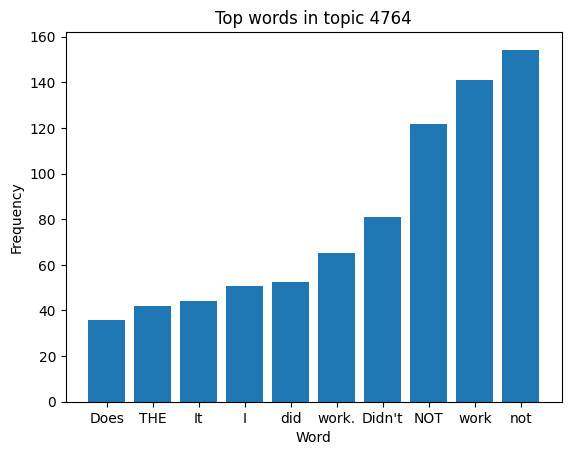

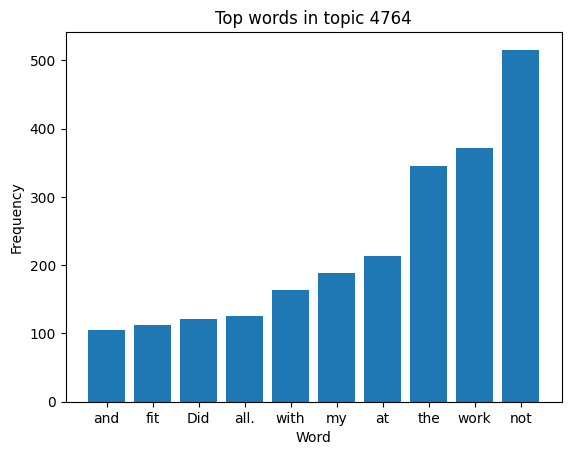

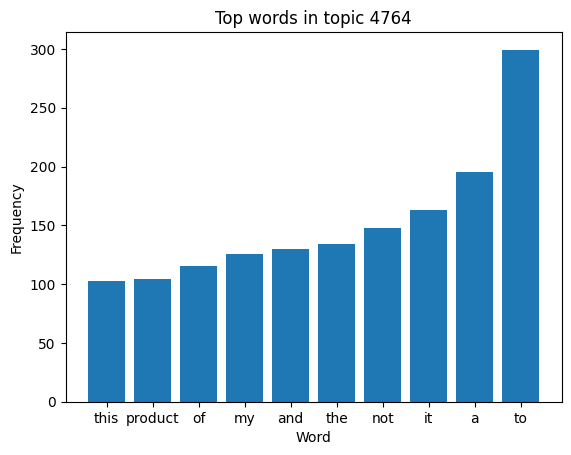

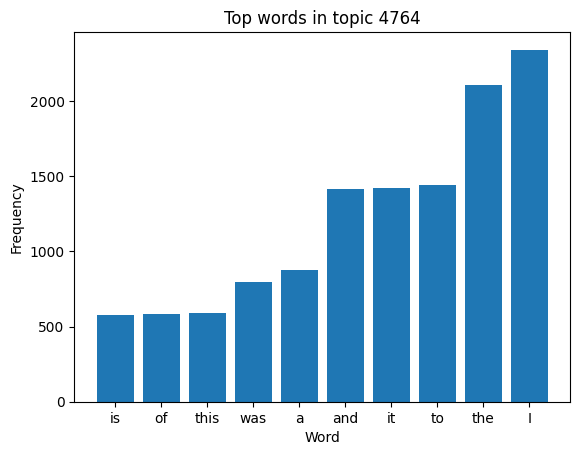

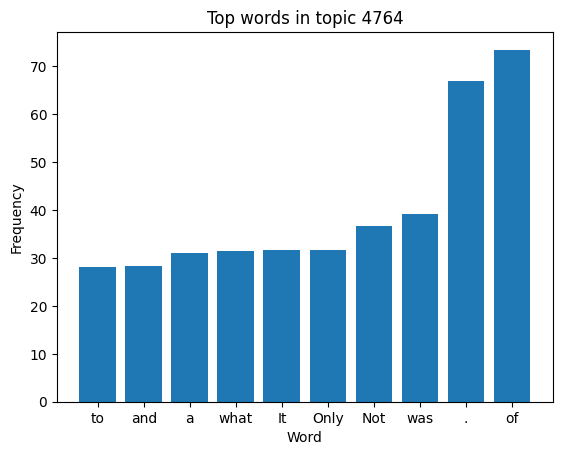

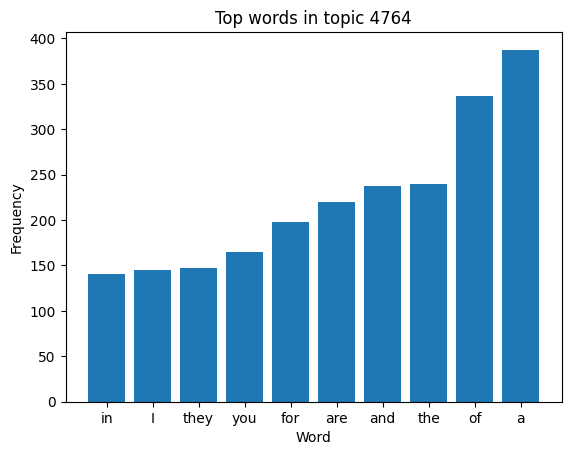

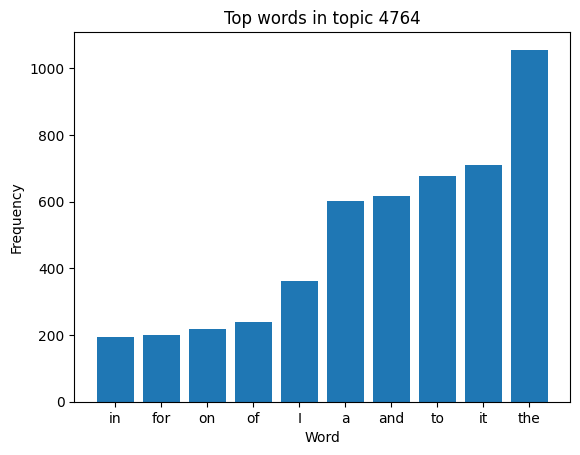

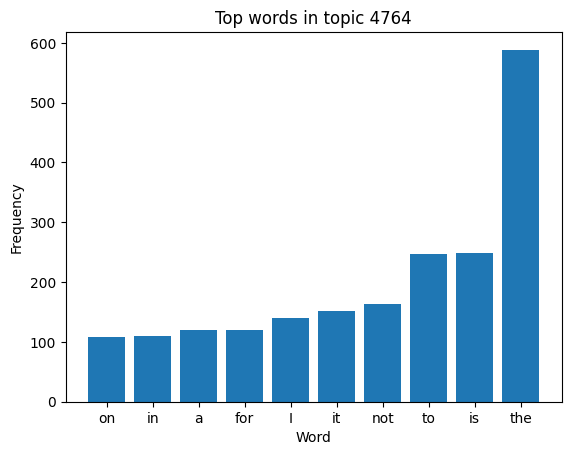

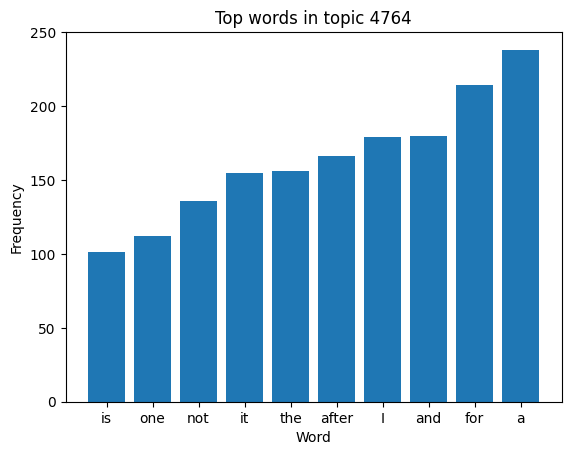

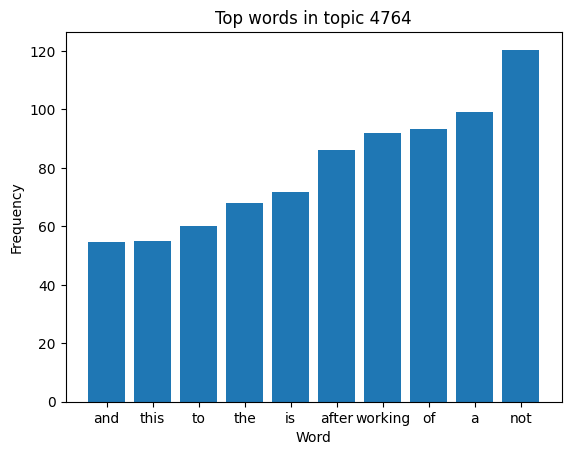

In [ ]:
# Plot the top words in each topic
for topic in topics:
    top_words = np.argsort(topic)[-10:]

    plt.bar(range(10), topic[top_words])
    plt.xticks(range(10), [vocabulary[i] for i in top_words])
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.title('Top words in topic {}'.format(i))
    plt.show()


In [ ]:
from transformers import pipeline

# Load the model
nlp = pipeline('text-classification', model='LiYuan/amazon-review-sentiment-analysis')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:58: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version inst

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
while True:
  # user input
  review = input("Enter a review: ")

  # if the user enters "exit", break out of the loop
  if review == "exit":
    break

  # print the sentiment score and show the label (review rating)
  print(nlp(review))

Enter a review: Requires more power than expected.
[{'label': '5 stars', 'score': 0.5400812029838562}]
Enter a review: This is a review
[{'label': '5 stars', 'score': 0.6465663909912109}]
Enter a review: This was horrible. I will never buy this again
[{'label': '1 star', 'score': 0.9573968648910522}]
Enter a review: Wow this is amazing
[{'label': '5 stars', 'score': 0.9732267260551453}]
Enter a review: Charging is great but it doesn't last as long.
[{'label': '3 stars', 'score': 0.5234842300415039}]
Enter a review: Average product quality
[{'label': '3 stars', 'score': 0.8359939455986023}]
Enter a review: exit


In [ ]:
def sentiments(x):
    return nlp(x, max_length = 512, truncation=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# taking a sample of 400 reviews
df_sentiment = data_df.iloc[1:400]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# get entire review
df_sentiment['review'] = df_sentiment['review_headline'] + ' ' + df_sentiment['review_body']

df_sentiment.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


product_title  star_rating  \
2                               hosa trs trs adaptor          5.0   
3          channel master titan antenna preamplifier          5.0   
4  limtech wall charger usb hotsync charging dock...          1.0   
5     skullcandy air raid portable bluetooth speaker          5.0   
6  pioneer andrew jones designed bookshelf loudsp...          5.0   

  helpful_votes total_votes verified_purchase                review_headline  \
2             0           0                 Y       It works as advertising.   
3             1           1                 Y                     Five Stars   
4             0           0                 Y                       One Star   
5             1           1                 Y  Overall pleased with the item   
6             1           1                 Y                     Five Stars   

                                         review_body review_date  \
2                           It works as advertising.  2015-08-31   
3                                        Works pissa  2015-08-31   
4                               Did not work at all.  2015-08-31   
5  Works well. Bass is somewhat lacking but is pr...  2015-08-31   
6  The quality on these speakers is insanely good...  2015-08-31   

                                              review  
2  It works as advertising. It works as advertising.  
3                             Five Stars Works pissa  
4                      One Star Did not work at all.  
5  Overall pleased with the item Works well. Bass...  
6  Five Stars The quality on these speakers is in...

In [ ]:
# call sentiments function
df_sentiment['sentiment'] = df_sentiment['review'].apply(lambda x: sentiments(x))

df_sentiment.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


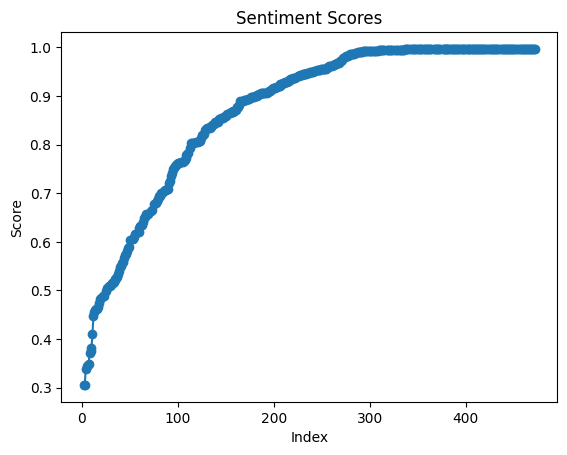

In [ ]:
# plot sentiment score
df_sentiment['score'] = df_sentiment['sentiment'].apply(lambda x: x[0]['score'])

plt.plot(df_sentiment.index, sorted(df_sentiment['score']), marker='o')
plt.xlabel('Index')
plt.ylabel('Score')
plt.title('Sentiment Scores')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


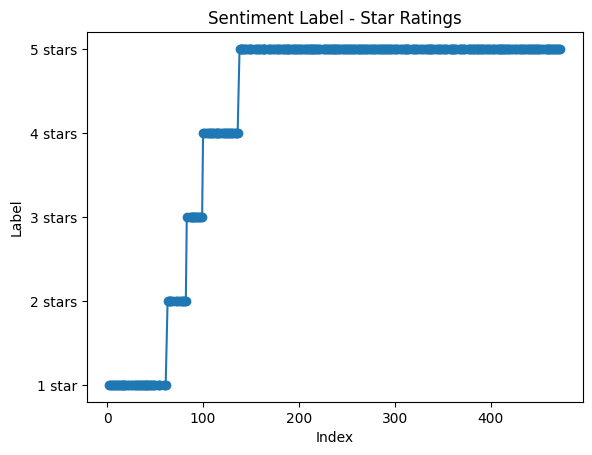

In [ ]:
# plot labels
df_sentiment['lab'] = df_sentiment['sentiment'].apply(lambda x: x[0]['label'])

plt.plot(df_sentiment.index, sorted(df_sentiment['lab']), marker='o')
plt.xlabel('Index')
plt.ylabel('Label')
plt.title('Sentiment Label - Star Ratings')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


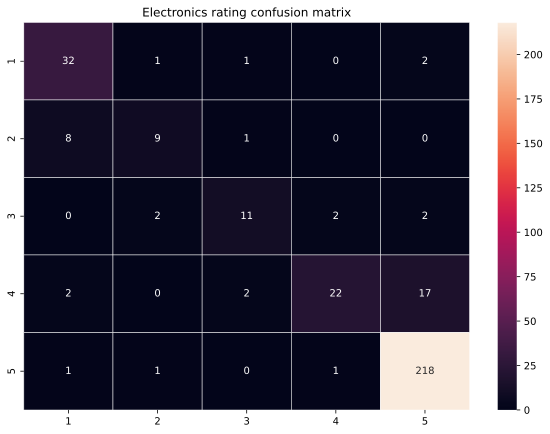

In [ ]:
# Confusion Matrix
%config InlineBackend.figure_format = 'svg'
from sklearn.metrics import confusion_matrix

for i in range(df_sentiment.shape[0]):
  try:
    star = int(nlp(df_sentiment.at[i, 'review'])[0]['label'].split(' ')[0])
    df_sentiment.at[i, 'prediction'] = star
  except:
    pass

df_drop = df_sentiment.dropna()
df_drop = df_drop.astype({'prediction': 'int', 'star_rating': 'int'})

array = confusion_matrix(y_true=df_drop['star_rating'], y_pred=df_drop['prediction'], labels = [1,2,3,4,5])

df_cm = pd.DataFrame(array, index = [i for i in [1,2,3,4,5]],
                  columns = [i for i in [1,2,3,4,5]])

plt.figure(figsize = (10,7))
ax = plt.axes()

sns.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax);
ax.set_title('Electronics rating confusion matrix')

plt.show()

In [ ]:
# experiment where I tried removing reviews rated 2 and 4 stars
df_new = data_df[(data_df.star_rating != 2) & (data_df.star_rating != 4)]

df_new.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


product_title  star_rating  \
1  yoomall antenna wifi rpsma female male extensi...          5.0   
2                               hosa trs trs adaptor          5.0   
3          channel master titan antenna preamplifier          5.0   
4  limtech wall charger usb hotsync charging dock...          1.0   
5     skullcandy air raid portable bluetooth speaker          5.0   

  helpful_votes total_votes verified_purchase                review_headline  \
1             0           0                 Y                     Five Stars   
2             0           0                 Y       It works as advertising.   
3             1           1                 Y                     Five Stars   
4             0           0                 Y                       One Star   
5             1           1                 Y  Overall pleased with the item   

                                         review_body review_date  \
1                                      As described.  2015-08-31   
2                           It works as advertising.  2015-08-31   
3                                        Works pissa  2015-08-31   
4                               Did not work at all.  2015-08-31   
5  Works well. Bass is somewhat lacking but is pr...  2015-08-31   

                                              review  
1                          Five Stars. As described.  
2  It works as advertising.. It works as advertis...  
3                            Five Stars. Works pissa  
4                     One Star. Did not work at all.  
5  Overall pleased with the item. Works well. Bas...

In [ ]:
# getting the column names
df.columns = list(df.iloc[0])

df['star_rating'] = pd.to_numeric(df['star_rating'], errors='coerce')

training_df = df.iloc[1:100000]

training_df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


marketplace customer_id       review_id  product_id product_parent  \
1          US    41409413  R2MTG1GCZLR2DK  B00428R89M      112201306   
2          US    49668221  R2HBOEM8LE9928  B000068O48      734576678   
3          US    12338275  R1P4RW1R9FDPEE  B000GGKOG8      614448099   
4          US    38487968  R1EBPM82ENI67M  B000NU4OTA       72265257   
5          US    23732619  R372S58V6D11AT  B00JOQIO6S      308169188   

                                       product_title product_category  \
1  yoomall 5M Antenna WIFI RP-SMA Female to Male ...      Electronics   
2         Hosa GPM-103 3.5mm TRS to 1/4" TRS Adaptor      Electronics   
3        Channel Master Titan 2 Antenna Preamplifier      Electronics   
4  LIMTECH Wall charger + USB Hotsync & Charging ...      Electronics   
5     Skullcandy Air Raid Portable Bluetooth Speaker      Electronics   

   star_rating helpful_votes total_votes vine verified_purchase  \
1          5.0             0           0    N                 Y   
2          5.0             0           0    N                 Y   
3          5.0             1           1    N                 Y   
4          1.0             0           0    N                 Y   
5          5.0             1           1    N                 Y   

                 review_headline  \
1                     Five Stars   
2       It works as advertising.   
3                     Five Stars   
4                       One Star   
5  Overall pleased with the item   

                                         review_body review_date  
1                                      As described.  2015-08-31  
2                           It works as advertising.  2015-08-31  
3                                        Works pissa  2015-08-31  
4                               Did not work at all.  2015-08-31  
5  Works well. Bass is somewhat lacking but is pr...  2015-08-31

In [ ]:
# dataset preparation
batch_size = 16

training_df['review'] = training_df['review_headline'] + ". " + training_df['review_body']
product = training_df[['review', 'star_rating']]
product = product.rename(columns={'review': 'text', 'star_rating': 'label'})
alled = product

from sklearn.model_selection import train_test_split

frac_train = 0.9
frac_test = 0.8

train_all, test = train_test_split(alled, train_size=frac_train, shuffle=True)
train, dev = train_test_split(train_all, train_size=frac_test, shuffle=True)

train = train.dropna()
dev = dev.dropna()
test = test.dropna()
print('Before training shape:',train.shape)
print('Before dev shape:',dev.shape)
print('Before test shape:',test.shape)

train.reset_index(drop=True, inplace=True)
dev.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

train = train.astype({'label': int})
dev = dev.astype({'label': int})
test = test.astype({'label': int})

train['label'] = train['label'] - 1
dev['label'] = dev['label'] - 1
test['label'] = test['label'] - 1

# Save each data
train.to_csv("../content/train.csv", index=False)
dev.to_csv("../content/dev.csv", index=False)
test.to_csv("../content/test.csv", index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Before training shape: (71993, 2)
Before dev shape: (17998, 2)
Before test shape: (10000, 2)


In [ ]:
# model training
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

# Load data
data = pd.read_csv("train.csv")
texts = data['text'].tolist()
labels = data['label'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
vocab_size = len(tokenizer.word_index) + 1

# Convert text to sequences and pad sequences
sequences = tokenizer.texts_to_sequences(texts)
max_len = max(len(seq) for seq in sequences)
X = pad_sequences(sequences, maxlen=max_len, padding='post')

# Label encoding
y = pd.get_dummies(labels).values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build LSTM model
# This can be replaced with any architecture for easy model testing
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len))
model.add(LSTM(100))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=200, validation_split=0.2)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Epoch 1/5
231/231 [==============================] - 99s 422ms/step - loss: 1.1852 - accuracy: 0.6120 - val_loss: 1.1819 - val_accuracy: 0.6126
Epoch 2/5
231/231 [==============================] - 95s 410ms/step - loss: 1.1719 - accuracy: 0.6145 - val_loss: 1.1776 - val_accuracy: 0.6126
Epoch 3/5
231/231 [==============================] - 94s 408ms/step - loss: 1.1715 - accuracy: 0.6145 - val_loss: 1.1791 - val_accuracy: 0.6126
Epoch 4/5
231/231 [==============================] - 93s 402ms/step - loss: 1.1713 - accuracy: 0.6145 - val_loss: 1.1765 - val_accuracy: 0.6126
Epoch 5/5
450/450 [==============================] - 55s 121ms/step - loss: 1.1648 - accuracy: 0.6187
Test Accuracy: 61.87%


In [ ]:
# model evaluation
import numpy as np

# Function to preprocess and predict sentiment
def predict_sentiment(model, tokenizer, text):
    # Tokenize and pad the input text
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post')

    # Make predictions
    predictions = model.predict(padded_sequence)
    sentiment_score = np.argmax(predictions)

    return sentiment_score

# Example usage
input_text = "This product is amazing! I love it."
predicted_sentiment = predict_sentiment(model, tokenizer, input_text)

print(f"Input Text: {input_text}")
print(f"Predicted Sentiment Score: {predicted_sentiment}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 0s 413ms/step
Input Text: This product is amazing! I love it.
Predicted Sentiment Score: 4


In [ ]:
# Example usage
input_text = "Works well but needs more power"
predicted_sentiment = predict_sentiment(model, tokenizer, input_text)

print(f"Input Text: {input_text}")
print(f"Predicted Sentiment Score: {predicted_sentiment}")

1/1 [==============================] - 0s 81ms/step
Input Text: Works well but needs more power
Predicted Sentiment Score: 4


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Example usage
input_text = "Require more power than expected."
predicted_sentiment = predict_sentiment(model, tokenizer, input_text)

print(f"Input Text: {input_text}")
print(f"Predicted Sentiment Score: {predicted_sentiment}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 0s 85ms/step
Input Text: Require more power than expected.
Predicted Sentiment Score: 4


In [ ]:
# Example usage
input_text = "Really bad. Would not recommend"
predicted_sentiment = predict_sentiment(model, tokenizer, input_text)

print(f"Input Text: {input_text}")
print(f"Predicted Sentiment Score: {predicted_sentiment}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1/1 [==============================] - 0s 82ms/step
Input Text: Really bad. Would not recommend
Predicted Sentiment Score: 4
